# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [23]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
import timeit

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Подгрузили все необходимые модули

Загрузили датасет. В общем получили 354369 объектов и 16 признаков

In [3]:
data.info()
print()
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Изучили типы данных и пропуски. Пропусков довольно много и после мук выбора (я правда думал и подбирал варианты), пришел к выводу, что пропуски в заполненном виде только испортят нам точные данные и могут привети к ухудшению качества модели. Для прямого анализа, думаю, стоило заполнять, но в случае предсказаний и обучения модели, такой исход считаю лучшим на данный момент. Остающееся количество данных достаточное для обучения модели.

In [4]:
data.dropna(inplace=True)

In [5]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 16 columns):
DateCrawled          245814 non-null datetime64[ns]
Price                245814 non-null int64
VehicleType          245814 non-null object
RegistrationYear     245814 non-null int64
Gearbox              245814 non-null object
Power                245814 non-null int64
Model                245814 non-null object
Kilometer            245814 non-null int64
RegistrationMonth    245814 non-null int64
FuelType             245814 non-null object
Brand                245814 non-null object
NotRepaired          245814 non-null object
DateCreated          245814 non-null datetime64[ns]
NumberOfPictures     245814 non-null int64
PostalCode           245814 non-null int64
LastSeen             245814 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 31.9+ MB


In [6]:
data = data.query("Price != 0").reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242428 entries, 0 to 242427
Data columns (total 17 columns):
index                242428 non-null int64
DateCrawled          242428 non-null datetime64[ns]
Price                242428 non-null int64
VehicleType          242428 non-null object
RegistrationYear     242428 non-null int64
Gearbox              242428 non-null object
Power                242428 non-null int64
Model                242428 non-null object
Kilometer            242428 non-null int64
RegistrationMonth    242428 non-null int64
FuelType             242428 non-null object
Brand                242428 non-null object
NotRepaired          242428 non-null object
DateCreated          242428 non-null datetime64[ns]
NumberOfPictures     242428 non-null int64
PostalCode           242428 non-null int64
LastSeen             242428 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(8), object(6)
memory usage: 31.4+ MB


In [7]:
data['RegistrationYear'].describe()

count    242428.000000
mean       2002.972186
std           6.136409
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: RegistrationYear, dtype: float64

In [8]:
data['Power'].describe()

count    242428.000000
mean        120.106559
std         136.958457
min           0.000000
25%          75.000000
50%         111.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

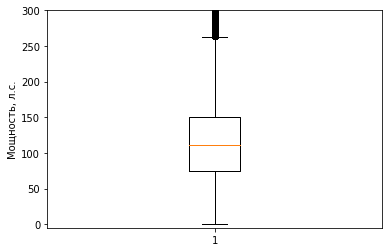

In [9]:
plt.boxplot(data['Power'])
plt.ylabel('Мощность, л.с.')
plt.ylim(-5, 300)
plt.show()

In [10]:
print(len(data.query('Power <50 ')))

12327


In [11]:
data = data.query('Power <= 260')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237446 entries, 0 to 242427
Data columns (total 17 columns):
index                237446 non-null int64
DateCrawled          237446 non-null datetime64[ns]
Price                237446 non-null int64
VehicleType          237446 non-null object
RegistrationYear     237446 non-null int64
Gearbox              237446 non-null object
Power                237446 non-null int64
Model                237446 non-null object
Kilometer            237446 non-null int64
RegistrationMonth    237446 non-null int64
FuelType             237446 non-null object
Brand                237446 non-null object
NotRepaired          237446 non-null object
DateCreated          237446 non-null datetime64[ns]
NumberOfPictures     237446 non-null int64
PostalCode           237446 non-null int64
LastSeen             237446 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(8), object(6)
memory usage: 32.6+ MB


In [12]:
encoder_1 = OrdinalEncoder()
encoder_1.fit(data[['Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']])
data[['Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']] = encoder_1.fit_transform(data[['Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']])
display(data.head())

,index,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,3,2016-03-17 16:54:04,1500,small,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0,2016-03-17,0,91074,2016-03-17 17:40:17
1,4,2016-03-31 17:25:20,3600,small,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,2016-03-31,0,60437,2016-04-06 10:17:21
2,5,2016-04-04 17:36:23,650,sedan,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,2016-04-04,0,33775,2016-04-06 19:17:07
3,6,2016-04-01 20:48:51,2200,convertible,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,2016-04-01,0,67112,2016-04-05 18:18:39
4,10,2016-03-26 19:54:18,2000,sedan,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,2016-03-26,0,96224,2016-04-06 10:45:34


In [13]:
data_for_coding = pd.get_dummies(data[['VehicleType']], drop_first=True)
display(data_for_coding)

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
242423,0,0,0,0,0,0,1
242424,0,0,0,1,0,0,0
242425,0,0,0,0,0,0,0
242426,1,0,0,0,0,0,0


Принято решение кодировать часть данных для более комфортного восприятия моделью. Для коробки, типа топлива и статуса ремонта выбран *OrdinalEncoder*, для типа кузова, модели и марки автомобиля выбрано прямое кодирование из-за обилия вариантов, так как применяя другую технику мы могли бы получить более близкие значения у BMW и Toyota, когда к BMW ближе AUDI, например

In [14]:
data_split = pd.concat([data, data_for_coding], axis = 1).drop(
    ['VehicleType', 'index', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)
display(data_split)

,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon
0,1500,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0,0,0,0,0,0,1,0,0
1,3600,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,0,0,0,0,0,1,0,0
2,650,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,0,0,0,0,1,0,0,0
3,2200,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,0,1,0,0,0,0,0,0
4,2000,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242423,3999,2005,1.0,3,11.0,150000,5,2.0,2.0,0.0,0,0,0,0,0,0,0,1
242424,3200,2004,1.0,225,140.0,150000,5,6.0,30.0,1.0,0,0,0,0,1,0,0,0
242425,1150,2000,1.0,0,247.0,150000,3,6.0,24.0,0.0,0,0,0,0,0,0,0,0
242426,1199,2000,0.0,101,106.0,125000,3,6.0,32.0,0.0,0,1,0,0,0,0,0,0


Сшиваем обычным *concat*, так как порядок не изменился

In [15]:
features = data_split.drop(['Price'], axis=1)
target = data_split['Price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print('Размер обучающей выборки:', len(features_train))
print('Размер валидационной выборки:', len(features_valid))

Размер обучающей выборки: 178084
Размер валидационной выборки: 59362


Делим датасет на признаки и таргет

## Обучение моделей

In [25]:
model_list = ['RandomForestRegressor', 'LinearRegression', 'LGBMRegressor', 'CatBoostRegressor']
rmse_list = []
time_list = []

In [26]:

start_time = timeit.default_timer()
model = RandomForestRegressor(n_estimators=80, max_depth=7, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

result_0 = mean_squared_error(target_valid, predictions)**0.5
time_0 = timeit.default_timer() - start_time

rmse_list.append(result_0)
time_list.append(time_0)


In [27]:
start_time = timeit.default_timer()

model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

result_0 = mean_squared_error(target_valid, predictions)**0.5
time_0 = timeit.default_timer() - start_time

rmse_list.append(result_0)
time_list.append(time_0)


In [28]:
start_time = timeit.default_timer()

model = lgb.LGBMRegressor(n_estimators=150, max_depth=9, learning_rate=1, boosting_type='dart',random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

result_0 = mean_squared_error(target_valid, predictions)**0.5
time_0 = timeit.default_timer() - start_time

rmse_list.append(result_0)
time_list.append(time_0)


In [29]:
start_time = timeit.default_timer()

model = CatBoostRegressor(depth=7, loss_function='RMSE', verbose=False)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

result_0 = mean_squared_error(target_valid, predictions)**0.5
time_0 = timeit.default_timer() - start_time

rmse_list.append(result_0)
time_list.append(time_0)


## Анализ моделей

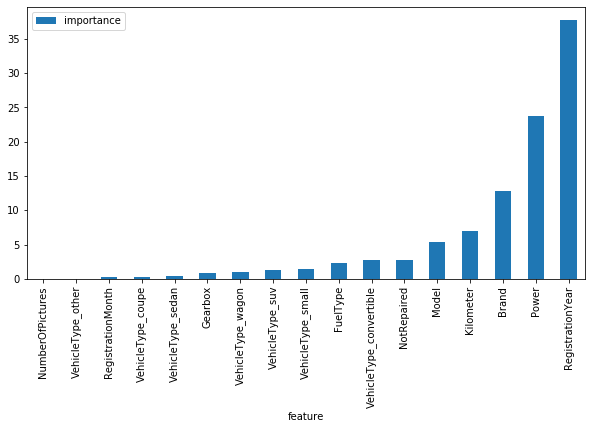

In [34]:
importances = model.feature_importances_
feature_list = list(features_valid.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances}).sort_values('importance')


feature_results.sort_values(by='importance').plot(x='feature', y='importance', kind='bar', figsize=(10,5))

In [31]:
data_results = pd.DataFrame({'model':model_list, 'RMSE':rmse_list, 'time':time_list})
display(data_results)

,model,RMSE,time
0,RandomForestRegressor,2102.678002,22.261359
1,LinearRegression,2887.800392,0.123952
2,LGBMRegressor,1559.602422,31.528448
3,CatBoostRegressor,1595.116441,155.655887


Создал гистограмму важности признаков. По итогам стало очевидно, что самыми значимыми параметрами являются год регистрации ТС, мощность, бренд, пробег и модель автомобиля, остальные признаки оказывают меньшее влияние на модель

Вывел результаты работы в таблицу, где наглядно представлены метрики и время работы моделей. Самая эффективная, на мой взгляд, модель все та же - это *LGBMRegressor*